Source:
- https://lifetimes.readthedocs.io/en/latest/Quickstart.html

In [1]:
import os

PROJECT_ID = os.getenv("GCP_PROJECT_ID")

In [2]:
! pip install lifetimes pandas-gbq seaborn

In [3]:
import pandas as pd

data_bq = pd.read_gbq(f"SELECT * FROM `{PROJECT_ID}.richemont.rfm`")

In [4]:
data = data_bq.set_index("client_id").astype(float)

## Basic Frequency/Recency analysis using the BG/NBD model

In [5]:
from lifetimes import BetaGeoFitter

In [6]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 52855 subjects, a: 0.48, alpha: 77.55, b: 0.34, r: 0.03>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

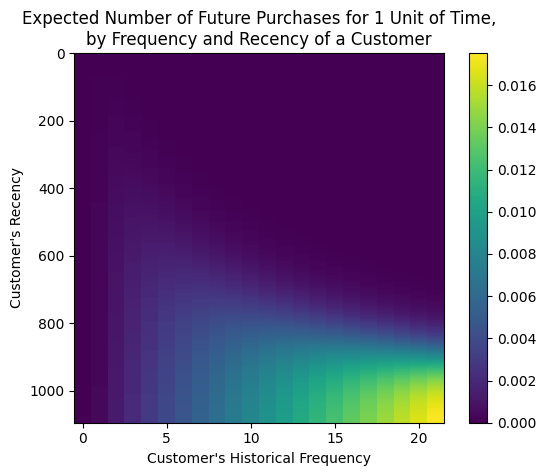

In [7]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

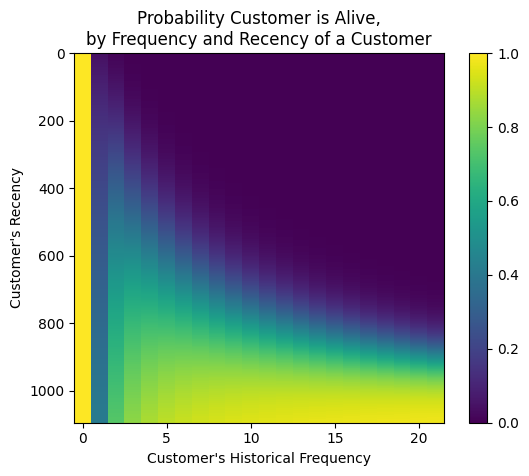

In [8]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [9]:
period = 7 # one week
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(period, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,monetary_value,T,predicted_purchases
client_id,,,,,
0011i00000nJv5xAAH,18.0,1058.0,44452.428622,1067.0,0.106706
0011i00000nLRgRAAW,20.0,1026.0,22771.100618,1058.0,0.118102
0011i00000nL6gLAAS,2.0,4.0,8141.382628,4.0,0.125587
0011i00000ngSiIAAU,17.0,716.0,18279.316145,751.0,0.135311
0011i00000nLPKSAA4,21.0,734.0,18555.343688,805.0,0.146379


Great, we can see that the customer who has made 26 purchases, and bought very recently from us, is probably going to buy again in the next period.

## Estimating customer lifetime value using the Gamma-Gamma model

In [10]:
summary_with_money_value = data.drop('predicted_purchases', axis=1).copy()
summary_with_money_value.head()

,frequency,recency,monetary_value,T
client_id,,,,
0011i00000YQyhiAAD,0.0,0.0,4616.771095,0.0
0011i00000SzZ0zAAF,0.0,0.0,9763.105440,0.0
0011i00000j8Tv3AAE,0.0,0.0,6419.764463,0.0
0011i00000S5a6uAAB,0.0,0.0,21322.456265,0.0
0011i00000nKuKQAA0,0.0,0.0,6990.801006,0.0


In [11]:
returning_customers_summary = data.drop('predicted_purchases', axis=1)[data['frequency']>0]
returning_customers_summary.head()

,frequency,recency,monetary_value,T
client_id,,,,
0011i00000ngVmFAAU,1.0,34.0,12609.940355,256.0
0011i00000j8JqOAAU,1.0,35.0,12818.099767,256.0
0011i00000ngUWyAAM,1.0,310.0,8437.191198,512.0
0011i00000nLPRRAA4,1.0,410.0,15375.207351,768.0
0011i00000nJcO9AAK,1.0,1019.0,7608.972236,1024.0


In [12]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.057115
frequency,0.057115,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [13]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2767 subjects, p: 100.52, q: 3.89, v: 384.73>

In [14]:
ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    )

client_id
0011i00000YQyhiAAD    13376.792957
0011i00000SzZ0zAAF    13376.792957
0011i00000j8Tv3AAE    13376.792957
0011i00000S5a6uAAB    13376.792957
0011i00000nKuKQAA0    13376.792957
                          ...     
0011i00000ngSiIAAU    18271.036048
0011i00000nKE81AAG    18954.070190
0011i00000nJv5xAAH    44402.854738
0011i00000nLRgRAAW    22757.610694
0011i00000nLPKSAA4    18548.261078
Length: 52855, dtype: float64

In [15]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 13407.637463549823, Average profit: 13971.305612615923


In [16]:
avg_profit = ggf.conditional_expected_average_profit(
    summary_with_money_value['frequency'],
    summary_with_money_value['monetary_value']
)

In [19]:
avg_profit

client_id
0011i00000YQyhiAAD    13376.792957
0011i00000SzZ0zAAF    13376.792957
0011i00000j8Tv3AAE    13376.792957
0011i00000S5a6uAAB    13376.792957
0011i00000nKuKQAA0    13376.792957
                          ...     
0011i00000ngSiIAAU    18271.036048
0011i00000nKE81AAG    18954.070190
0011i00000nJv5xAAH    44402.854738
0011i00000nLRgRAAW    22757.610694
0011i00000nLPKSAA4    18548.261078
Length: 52855, dtype: float64

In [17]:
import seaborn as sns

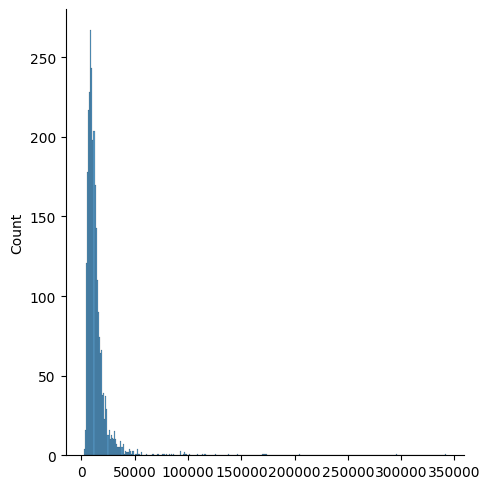

In [22]:
sns.displot(avg_profit.loc[returning_customers_summary.index])

In [26]:
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    # time=365, # months
    discount_rate=0# .01 # monthly discount rate ~ 12.7% annually
).head(10))

client_id
0011i00000YQyhiAAD    983.908958
0011i00000SzZ0zAAF    983.908958
0011i00000j8Tv3AAE    983.908958
0011i00000S5a6uAAB    983.908958
0011i00000nKuKQAA0    983.908958
0011i00000YQtMyAAL    983.908958
0011i00000S5ZqpAAF    983.908958
0011i00000YUWLnAAP    983.908958
0011i00000nKuK3AAK    983.908958
0011i00000SzZ15AAF    983.908958
Name: clv, dtype: float64


In [31]:
data.loc["0011i00000YQyhiAAD"]

frequency                 0.000000
recency                   0.000000
monetary_value         4616.771095
T                         0.000000
predicted_purchases       0.002554
Name: 0011i00000YQyhiAAD, dtype: float64